<a href="https://colab.research.google.com/github/liliya-ily/face_vae/blob/main/face_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# В данном проекте используются вариационные автоэнкодеры, для построения лиц знаменитостей

## Импортируются необходимые библиотеки

In [18]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

from glob import glob
# from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Model, regularizers
from tensorflow.keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2 as cv
import matplotlib.pyplot as plt

## Скачивание данных с kaggle.com

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files

In [6]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lilyily","key":"b4ffc25ec12416cfc425e1ce7c0b61ea"}'}

In [7]:
! mkdir ~/.kaggle

In [8]:
! cp kaggle.json ~/.kaggle/

In [9]:
 !chmod 600 ~/.kaggle/kaggle.json

In [10]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 3.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-cp37-none-any.whl size=73053 sha256=b6845c8d98347dc2c1174428cc1f1d04206931c0505634947b10f2ba0dbcd3d6
  Stored in directory: /root/.cache/pip/wheels/a1/6a/26/d30b7499ff85a4a4593377a87ecf55f7d08af42f0de9b60303
Successfully built kaggle
  Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [11]:
!kaggle datasets download -d jessicali9530/celeba-dataset

 99% 1.32G/1.33G [00:06<00:00, 216MB/s]
100% 1.33G/1.33G [00:06<00:00, 207MB/s]


In [ ]:
! unzip /content/celeba-dataset.zip -d kaggle 

В файле содержится более 200000 файлов, поэтому их приходится удалять, чтобы не перегружать colab



In [30]:
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/19*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/18*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/17*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/16*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/15*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/14*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/13*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/12*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/11*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/10*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/2*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/01*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/02*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/03*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/04*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/05*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/06*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/07*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/08*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/09*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/001*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/002*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/003*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/004*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/005*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/006*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/007*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/008*
!rm -f /content/kaggle/img_align_celeba/img_align_celeba/009*
# !ls /content/kaggle/img_align_celeba/img_align_celeba


Проверка загружаемых данных

In [ ]:
os.listdir('/content/kaggle/img_align_celeba/img_align_celeba/')

In [ ]:
# os.listdir('/content/kaggle/cats')

['CAT_04', 'CAT_05', 'CAT_03', 'CAT_01', 'CAT_06', 'CAT_00', 'CAT_02']

## Подготовка изображений

In [19]:
def img_preprocess():
    img_list = []
    for img_path in glob('/content/kaggle/img_align_celeba/img_align_celeba/*.jpg'):
        img = cv.imread(img_path)            # cv - 3-мерный массив, last_channel = 3, трехэлементный цвет RGB.
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB) # - OpenCV считывает изображения в BGR, а не RGB, поэтому нужно преобразование
        img = cv.resize(img, (180, 180))     # Преобразование формы в (224, 224)
        sc_img = img.astype('float') / 255   # Нормализация
        img_list.append(sc_img)
    
    return np.asarray(img_list)

In [20]:
img_arr = img_preprocess()

### Вывод полученных изображений

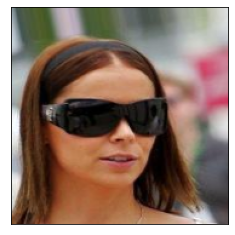

In [21]:
plt.imshow(img_arr[3]);
plt.xticks([]);
plt.yticks([]);

In [22]:
img_arr.shape

(999, 180, 180, 3)

## Построение модели VAE

## Разделение данных на x_train, x_test

In [23]:
from sklearn.model_selection import train_test_split
(x_train, x_test) = train_test_split(img_arr, test_size = 0.10, random_state = 0)


### Построение нейронной сети

In [32]:
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse


def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# network parameters
input_shape = (x_train.shape[1], x_train.shape[2], 3)
filters = 16
latent_dim = 32


inputs = Input(shape=input_shape, name='encoder_input')

x = inputs

for i in range(2):
    x = Conv2D(filters=filters,
               kernel_size=3,
               activation='relu',
               strides=2,
               padding='same')(x)
    filters *= 2

shape = K.int_shape(x)

x = Flatten()(x)

x = Dense(32, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')

x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    filters //= 2
    x = Conv2DTranspose(filters=filters,
                        kernel_size=3,
                        activation='relu',
                        strides=2,
                        padding='same')(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=3,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='vae')

reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
# reconstruction_loss *= x_train.shape[1]*x_train.shape[2]

kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5

vae_loss = K.mean(reconstruction_loss + 1e-3*kl_loss)
vae.add_loss(vae_loss)
vae.add_metric(reconstruction_loss, 'rec_loss')
vae.add_metric(kl_loss, 'kl_loss')

vae.compile(optimizer=keras.optimizers.Adam(lr=0.01))

vae.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 16)   448         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 45, 45, 32)   4640        conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 64800)        0           conv2d_3[0][0]                   
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "vae"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
encoder (Functional)            [(None, 32), (None,  2080832     encoder_input[0][0]              
__________________________________________________________________________________________________
decoder (Functional)            (None, 180, 180, 3)  2152707     encoder[0][2]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 90, 90, 16)   448         encoder_input[0][0]              
________________________________________________________________________________________________

AttributeError: ignored

In [25]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [26]:
vae.fit(
    x_train,
    x_train,
    epochs=40,
    batch_size=128,
    validation_data=(x_test, x_test),
#     callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=30, restore_best_weights=True)]
)

Epoch 1/40
8/8 [==============================] - 34s 4s/step - loss: 0.0993 - rec_loss: 0.0923 - kl_loss: 7.9654 - val_loss: 0.0915 - val_rec_loss: 0.0915 - val_kl_loss: 2.2528e-04
Epoch 2/40
8/8 [==============================] - 32s 4s/step - loss: 0.0936 - rec_loss: 0.0936 - kl_loss: 3.1376e-04 - val_loss: 0.0905 - val_rec_loss: 0.0905 - val_kl_loss: 4.3046e-04
Epoch 3/40
8/8 [==============================] - 32s 4s/step - loss: 0.0942 - rec_loss: 0.0942 - kl_loss: 4.7487e-04 - val_loss: 0.0891 - val_rec_loss: 0.0891 - val_kl_loss: 5.3144e-04
Epoch 4/40
8/8 [==============================] - 32s 4s/step - loss: 0.0927 - rec_loss: 0.0927 - kl_loss: 5.5509e-04 - val_loss: 0.0880 - val_rec_loss: 0.0880 - val_kl_loss: 6.0543e-04
Epoch 5/40
8/8 [==============================] - 32s 4s/step - loss: 0.0895 - rec_loss: 0.0895 - kl_loss: 6.5403e-04 - val_loss: 0.0872 - val_rec_loss: 0.0872 - val_kl_loss: 7.5802e-04
Epoch 6/40
8/8 [==============================] - 32s 4s/step - loss: 0.08

In [1]:
# for i in range(10):
#   plt.figure(figsize=(2,2))
#   plt.title(i)
#   plt.imshow(x_test[i])
#   plt.show()

In [27]:
test_rec = vae.predict(x_test)

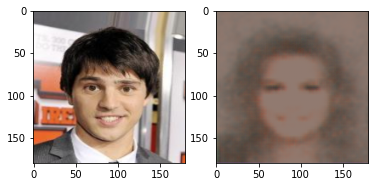

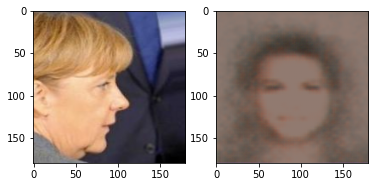

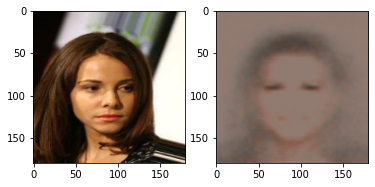

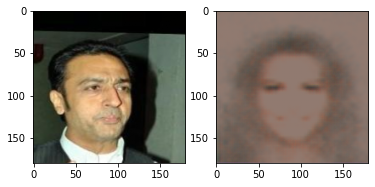

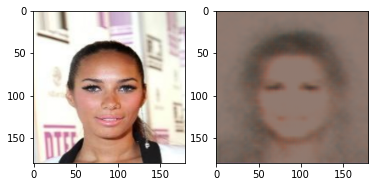

In [31]:

for i in range(5):
    fig, ax = plt.subplots(1, 2)
    
    ax[0].imshow(x_test[i+12], vmin=0, vmax=1)
    # plt.show()
    # plt.figure(figsize=(1,1))
    ax[1].imshow(test_rec[i+12], vmin=0, vmax=1)
    # plt.show()

NameError: ignored

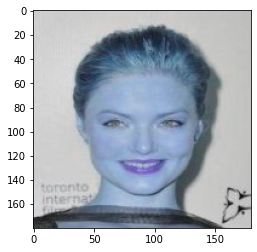

In [ ]:
i1, i2 = 85, 88

plt.imshow(x_test[i1])
plt.title(y_test[i1])
plt.show()
plt.imshow(x_test[i2])
plt.title(y_test[i2]);

## Cov2D

In [ ]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2,2),
                 strides=(2,2))(x)
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2),
                 strides=(2,2))(x)
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
encoder_layer = MaxPooling2D(pool_size=(2,2),
                             strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(encoder_layer)
x = UpSampling2D(size=(2,2))(x)              # Функция UpSampling2D заключается в усилении (восстановлении) вектора после традиционной свертки Down Sample.Это также можно назвать «деконволюцией».
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = UpSampling2D(size=(2,2))(x)
decoder_layer = Conv2D(filters=3, kernel_size=(3,3),
                       padding='same', activation='sigmoid')(x)

# Создание свёрточного AutoEncoder
conv_auto_encoder = Model(input_layer, decoder_layer)

# Создание Encoder
encoder = Model(input_layer, encoder_layer)


In [ ]:
conv_auto_encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0     

In [ ]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = EarlyStopping(monitor='val_loss',
                          patience=11,
                          restore_best_weights=True)

In [ ]:
history = conv_auto_encoder.fit(img_arr, img_arr,
                                epochs=30, batch_size=64,
                                validation_split=0.3,
                                shuffle=True,
                                callbacks=[callbacks])

Epoch 1/30
44/44 [==============================] - 54s 457ms/step - loss: 0.5725 - val_loss: 0.5047
Epoch 2/30
44/44 [==============================] - 13s 296ms/step - loss: 0.5003 - val_loss: 0.4964
Epoch 3/30
44/44 [==============================] - 13s 297ms/step - loss: 0.4918 - val_loss: 0.4873
Epoch 4/30
44/44 [==============================] - 13s 297ms/step - loss: 0.4875 - val_loss: 0.4865
Epoch 5/30
44/44 [==============================] - 13s 298ms/step - loss: 0.4854 - val_loss: 0.4832
Epoch 6/30
44/44 [==============================] - 13s 299ms/step - loss: 0.4849 - val_loss: 0.4825
Epoch 7/30
44/44 [==============================] - 14s 315ms/step - loss: 0.4842 - val_loss: 0.4815
Epoch 8/30
44/44 [==============================] - ETA: 0s - loss: 0.4827

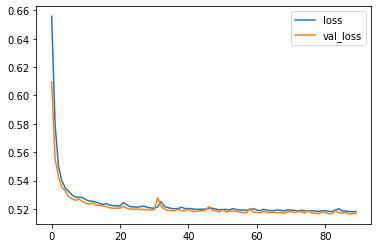

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
encoded = encoder.predict(img_arr)
decoded = conv_auto_encoder.predict(img_arr)

In [ ]:
print ('Low dimention shape: {}'.format(encoded[0].shape))
print ('output dimention shape: {}'.format(decoded[0].shape))

Low dimention shape: (28, 28, 32)
output dimention shape: (224, 224, 3)


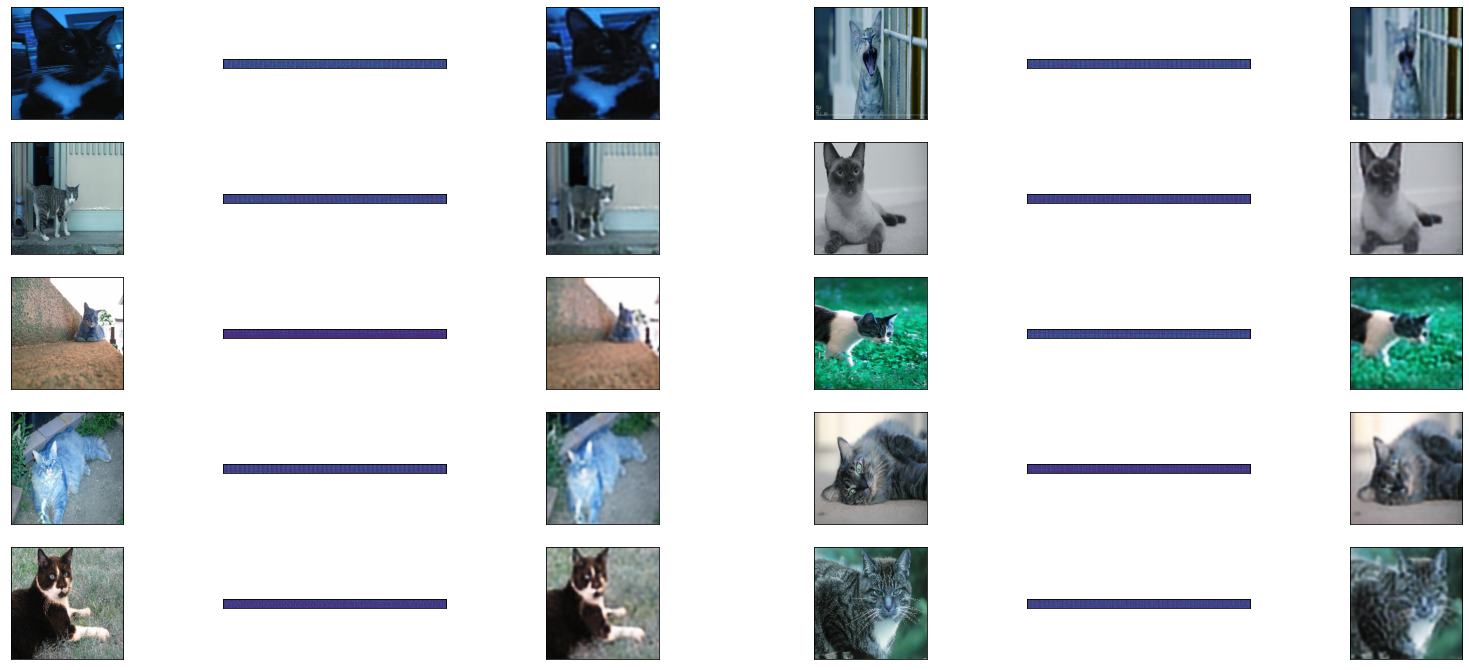

In [ ]:
fig = plt.figure(figsize=(28, 12))

n_plots = 10
n_row = int(n_plots / 2)
next = 10 # перебор всего модуля с картинками
for j in range(n_plots):
    # Исходное входное значение（Input)
    fig.add_subplot(n_row, 6, 3*j+1)
    plot_tmp = plt.imshow(img_arr[j+10])
    plt.xticks([])
    plt.yticks([])
    
    # Низкоразмерный массив
    fig.add_subplot(n_row, 6, 3*j+2)
    plot_tmp = plt.imshow(encoded[j+10].reshape(32, 784))
    plt.xticks([])
    plt.yticks([])
    
    # Восстановленные исходные данные (Deconded)
    fig.add_subplot(n_row, 6, 3*j+3)
    plot_tmp = plt.imshow(decoded[j+10])
    plt.xticks([])
    plt.yticks([])
    
plt.show()

## Conv2DTranspose 

In [ ]:
input_layer = Input(shape=(img_arr.shape[1], img_arr.shape[2], img_arr.shape[3]))

x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(input_layer)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
encoder_layer = MaxPooling2D(pool_size=(2,2), strides=(2,2))(x)

x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(encoder_layer)
x = Conv2DTranspose(filters=32,  kernel_size=(3,3),
                    strides=(2,2), padding='same',
                    use_bias=True, activation='relu')(x)
x = Conv2D(filters=32, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=32, kernel_size=(3,3),
                    strides=(2,2), padding='same',
                    use_bias=True, activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3),
           padding='same', activation='relu')(x)
x = Conv2DTranspose(filters=64, kernel_size=(3,3),
                    strides=(2,2), padding='same',
                    use_bias=True, activation='relu')(x)
decoder_layer = Conv2D(filters=3, kernel_size=(3,3),
                       padding='same', activation='sigmoid')(x)

# Создание Convolutional AutoEncoder
conv_auto_encoder = Model(input_layer, decoder_layer)

# Настройка Encoder
encoder = Model(input_layer, encoder_layer)

In [ ]:
conv_auto_encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 112, 112, 32)      18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 56, 56, 32)        9248      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 28, 28, 32)        0   

In [ ]:
conv_auto_encoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = EarlyStopping(monitor='val_loss',
                          patience=11,
                          restore_best_weights=True)

In [ ]:
history = conv_auto_encoder.fit(img_arr, img_arr,
                                epochs=300, batch_size=32,
                                validation_split=0.3,
                                shuffle=True,
                                callbacks=[callbacks])

Epoch 1/300
38/38 [==============================] - 11s 243ms/step - loss: 0.5174 - val_loss: 0.5163
Epoch 2/300
38/38 [==============================] - 8s 214ms/step - loss: 0.5170 - val_loss: 0.5159
Epoch 3/300
38/38 [==============================] - 8s 214ms/step - loss: 0.5177 - val_loss: 0.5155
Epoch 4/300
38/38 [==============================] - 8s 214ms/step - loss: 0.5165 - val_loss: 0.5153
Epoch 5/300
38/38 [==============================] - 8s 220ms/step - loss: 0.5170 - val_loss: 0.5154
Epoch 6/300
38/38 [==============================] - 8s 216ms/step - loss: 0.5176 - val_loss: 0.5152
Epoch 7/300
38/38 [==============================] - 8s 220ms/step - loss: 0.5166 - val_loss: 0.5150
Epoch 8/300
38/38 [==============================] - 8s 220ms/step - loss: 0.5168 - val_loss: 0.5166
Epoch 9/300
38/38 [==============================] - 8s 221ms/step - loss: 0.5168 - val_loss: 0.5149
Epoch 10/300
38/38 [==============================] - 8s 218ms/step - loss: 0.5164 - val_l

In [ ]:
encoded = encoder.predict(img_arr)
decoded = conv_auto_encoder.predict(img_arr)

NameError: ignored

In [ ]:
print ('encoded img shape {}'.format(encoded.shape))
print ('decoded img shape {}'.format(decoded.shape))

NameError: ignored

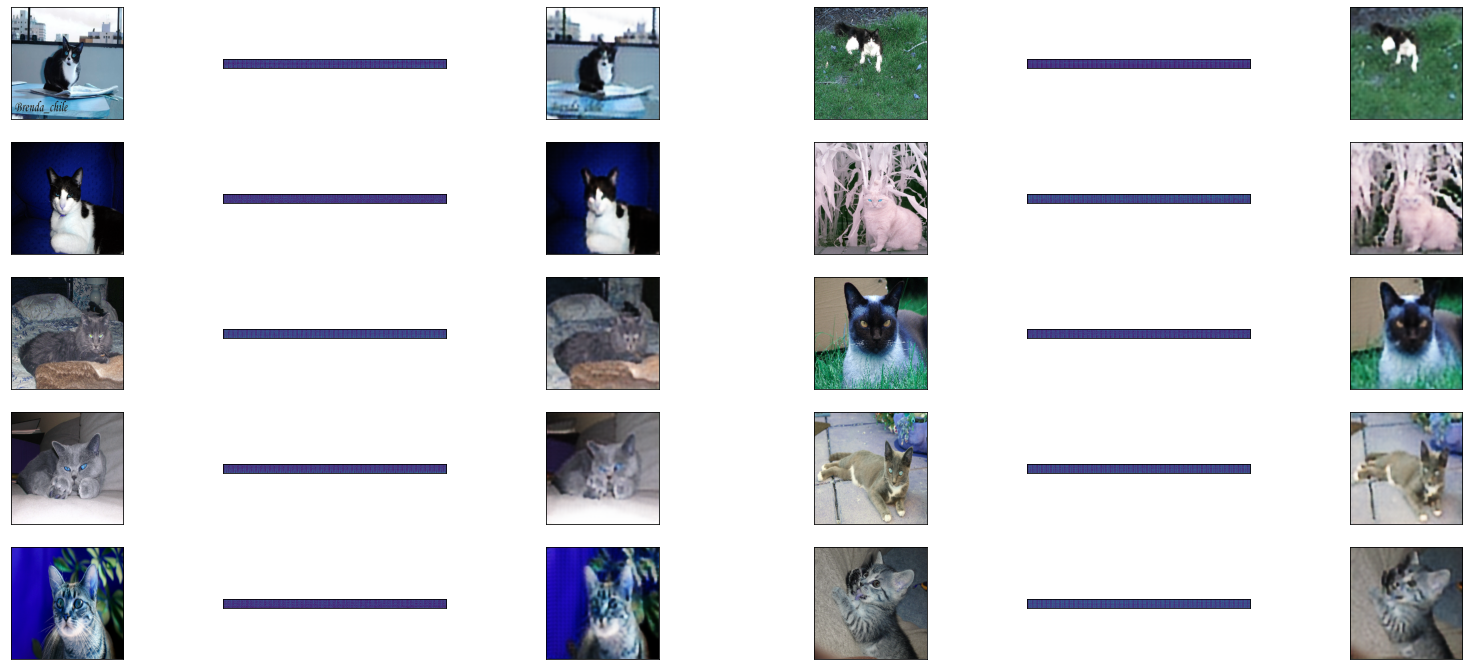

In [ ]:
fig = plt.figure(figsize=(28, 12))

n_plot = 10
n_rows = int(n_plot / 2)
next = 30
for j in range(n_plot):
    fig.add_subplot(n_rows, 6, 3*j+1)
    plot_tmp = plt.imshow(img_arr[j+next])
    plt.xticks([])
    plt.yticks([])
    
    fig.add_subplot(n_rows, 6, 3*j+2)
    plot_tmp = plt.imshow(encoded[j+next].reshape(32, 784))
    plt.xticks([])
    plt.yticks([])
    
    fig.add_subplot(n_rows, 6, 3*j+3)
    plot_tmp = plt.imshow(decoded[j+next])
    plt.xticks([])
    plt.yticks([])